In [1]:
!pip install git+https://github.com/PyLops/pylops-gpu.git


  Cloning https://github.com/PyLops/pylops-gpu.git to /tmp/pip-req-build-g6hb7uil
  Running command git clone -q https://github.com/PyLops/pylops-gpu.git /tmp/pip-req-build-g6hb7uil


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch
import torchvision
import torch.nn as nn
import pylops_gpu


from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from tqdm.notebook import tqdm_notebook, tnrange
from torch.autograd import gradcheck
from pylops_gpu.utils.backend import device
from torch.nn import MSELoss
from torch.utils.data import Dataset, DataLoader

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *

In [3]:
###### Input parameters
par = {'ox':-300,  'dx':10,    'nx':61,
       'oy':-500,  'dy':10,    'ny':101,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [1100.]
amp_m   = [1.]

t0_G    = [0.2,0.5,0.7]
vrms_G  = [1200.,1500., 2000.]
amp_G   = [1.,0.6,0.5]

ns = par['ny']
nr = par['nx']
nt = par['nt']
nfmax = par['nfmax']
dr = par['dx']
ds = par['dy']
dt = par['dt']
f0 = par['f0']

# Create taper for operator
tap = taper3d(nt, (ns,nr), [5,5], tapertype='hanning')

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0)[0]

# Generate model
m, mwav = hyperbolic2d(x,t,t0_m,vrms_m,amp_m,wav)

# Generate operator
G,Gwavoriginal = np.zeros((ns,nr,nt)), - \
         np.zeros((ns,nr,nt))
for iy,y0 in enumerate(y):
    G[iy],Gwavoriginal[iy] = hyperbolic2d(x-y0,t,t0_G,vrms_G,amp_G,wav)
G,Gwavoriginal = G*tap,Gwavoriginal*tap


Gwav = Gwavoriginal

In [4]:
# Add negative part to operator and model
ns = Gwav.shape[0]
m     = np.concatenate((np.zeros((nr, nt-1)), m), axis=-1).T
mwav  = np.concatenate((np.zeros((nr, nt-1)), mwav), axis=-1).T
Gwav2 = np.concatenate((np.zeros((ns, nr, nt-1)), Gwav), axis=-1)

Gwav2.shape

(101, 61, 799)

In [5]:
# Create frequency domain operator
Gwav_fft = np.fft.rfft(Gwav2, 2*nt-1, axis=-1)
Gwav_fft = Gwav_fft[...,:nfmax]
Gwav_fft = Gwav_fft.transpose(2,0,1)

# Create operator
MDCop=MDC(Gwav_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, 
          twosided=True, transpose=False)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=3, verb=True)

# Create data
d = MDCop*m.flatten()
d = d.reshape(2*nt-1, ns)

Dot test passed, v^T(Opu)=-4143.906090+9034.505638i - u^T(Op^Tv)=-4143.906090-2730.001403i


In [6]:

MDCop = pylops_gpu.TorchOperator(MDCop, pylops = True)
d =  torch.from_numpy(d.astype(np.float32))
m  =  torch.from_numpy(m.astype(np.float32))
Gwav2 = torch.from_numpy(Gwav2.astype(np.float32))

d1 = MDCop.apply(m.flatten())
d1 = d1.view(2*nt-1, ns)

In [7]:
nv=1
class GwavSGD(nn.Module):
  def __init__(self,nt,nv,dt,dr,ns):
    self.nt = nt
    self.nv = nv
    self.dt = dt
    self.dr =dr
    self.ns = ns
    super().__init__()


  def forward(self,model):
    
    MDCop=MDC(Gwav_fft, nt=2*self.nt-1, nv=self.nv, dt=self.dt, dr=self.dr, 
          twosided=True, transpose=False)
    
    MDCop = pylops_gpu.TorchOperator(MDCop, pylops = True)
    
    data = MDCop.apply(model.flatten())
    data = data.view(2*self.nt-1, self.ns)

    return data


In [8]:
lossdict = {}

# SGD optimization

In [9]:

model = np.zeros((m.shape[0], m.shape[1]))
model = torch.from_numpy(model)
model.requires_grad= True

criterion = nn.MSELoss()
optimizer = torch.optim.SGD([model], lr = 20, weight_decay= 0)

nv=1
GwavTorch = GwavSGD(nt,nv,dt,dr,ns)
lossHist=[]
for i in range(150):
    data = GwavTorch(model)
    lost = criterion(d1, data)
    loss = (1/Gwav2.shape[0]) * lost
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossHist.append(loss.item())
 
    
    if (i+1) %10 ==0:
     print(f'epoch: {i+1}, loss : {loss.item():.4f}')

lossdict["SGD"] = lossHist

epoch: 10, loss : 0.0036
epoch: 20, loss : 0.0019
epoch: 30, loss : 0.0012
epoch: 40, loss : 0.0009
epoch: 50, loss : 0.0007
epoch: 60, loss : 0.0006
epoch: 70, loss : 0.0005
epoch: 80, loss : 0.0004
epoch: 90, loss : 0.0003
epoch: 100, loss : 0.0003
epoch: 110, loss : 0.0003
epoch: 120, loss : 0.0002
epoch: 130, loss : 0.0002
epoch: 140, loss : 0.0002
epoch: 150, loss : 0.0002


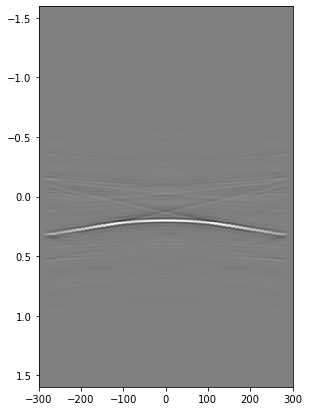

In [10]:
fig = plt.figure(figsize= (12,7))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-model.detach().numpy().max(), vmax=model.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))


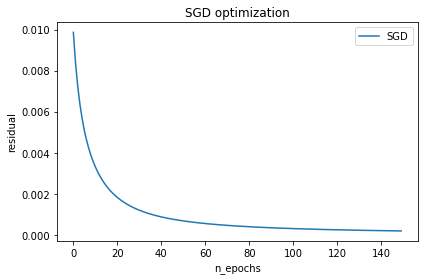

In [11]:
plt.plot(lossHist, label = "SGD")
plt.title('SGD optimization', fontsize=12)
plt.xlabel('n_epochs')
plt.ylabel('residual')
plt.legend()
plt.tight_layout()

# Adadelta optimization

In [12]:
model = np.zeros((m.shape[0], m.shape[1]))
model = torch.from_numpy(model)
model.requires_grad= True

criterion = nn.MSELoss()
optimizer1 = torch.optim.Adadelta([model], lr =60, rho= 0.9, weight_decay=0)


GwavTorch = GwavSGD(nt,nv,dt,dr,ns)
lossHist=[]
for i in range(150):
    data = GwavTorch(model)
    lost = criterion(d1, data)
    loss = (1/Gwav2.shape[0]) * lost
    loss.backward()
    optimizer1.step()
    optimizer1.zero_grad()

    lossHist.append(loss.item())
 
    
    if (i+1) %10 ==0:
     print(f'epoch: {i+1}, loss : {loss.item():.4f}')

lossdict["Adadelta"] = lossHist

epoch: 10, loss : 0.0013
epoch: 20, loss : 0.0006
epoch: 30, loss : 0.0004
epoch: 40, loss : 0.0002
epoch: 50, loss : 0.0002
epoch: 60, loss : 0.0002
epoch: 70, loss : 0.0001
epoch: 80, loss : 0.0001
epoch: 90, loss : 0.0001
epoch: 100, loss : 0.0001
epoch: 110, loss : 0.0001
epoch: 120, loss : 0.0001
epoch: 130, loss : 0.0001
epoch: 140, loss : 0.0001
epoch: 150, loss : 0.0001


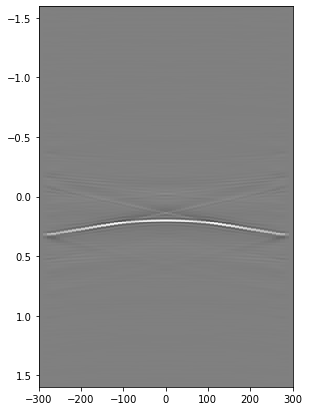

In [13]:
fig = plt.figure(figsize= (12,7))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-model.detach().numpy().max(), vmax=model.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))

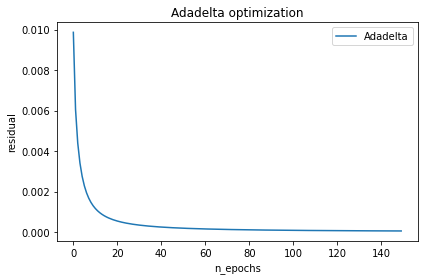

In [14]:
plt.plot(lossHist, label = "Adadelta")
plt.title('Adadelta optimization', fontsize=12)
plt.xlabel('n_epochs')
plt.ylabel('residual')
plt.legend()
plt.tight_layout()

# Adam optimization

In [15]:
model = np.zeros((m.shape[0], m.shape[1]))
model = torch.from_numpy(model)
model.requires_grad= True

criterion = nn.MSELoss()
optimizer2 = torch.optim.Adam([model], lr =0.01, eps = 1e-05)


GwavTorch = GwavSGD(nt,nv,dt,dr,ns)
lossHist=[]
for i in range(150):
    data = GwavTorch(model)
    lost = criterion(d1, data)
    loss = (1/Gwav2.shape[0]) * lost
    loss.backward()
    optimizer2.step()
    optimizer2.zero_grad()

    lossHist.append(loss.item())
 
    
    if (i+1) %10 ==0:
     print(f'epoch: {i+1}, loss : {loss.item():.4f}')

lossdict["Adam"] = lossHist

epoch: 10, loss : 0.0019
epoch: 20, loss : 0.0007
epoch: 30, loss : 0.0003
epoch: 40, loss : 0.0002
epoch: 50, loss : 0.0001
epoch: 60, loss : 0.0001
epoch: 70, loss : 0.0001
epoch: 80, loss : 0.0000
epoch: 90, loss : 0.0000
epoch: 100, loss : 0.0000
epoch: 110, loss : 0.0000
epoch: 120, loss : 0.0000
epoch: 130, loss : 0.0000
epoch: 140, loss : 0.0000
epoch: 150, loss : 0.0000


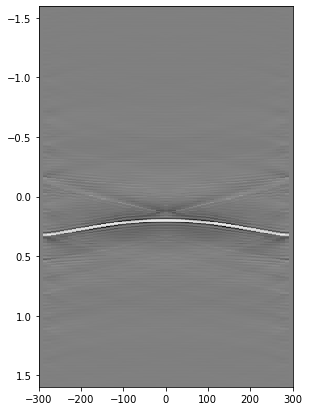

In [16]:
fig = plt.figure(figsize= (12,7))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-model.detach().numpy().max(), vmax=model.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))

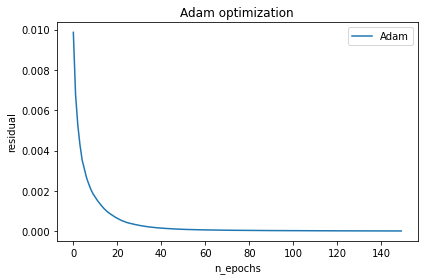

In [17]:
plt.plot(lossHist, label = "Adam")
plt.title('Adam optimization', fontsize=12)
plt.xlabel('n_epochs')
plt.ylabel('residual')
plt.legend()
plt.tight_layout()

# RMSprop optimization

In [18]:

model = np.zeros((m.shape[0], m.shape[1]))
model = torch.from_numpy(model)
model.requires_grad= True

criterion = nn.MSELoss()
optimizer3 = torch.optim.RMSprop([model], lr =0.01, alpha=0.8,eps = 1e-04)


GwavTorch = GwavSGD(nt,nv,dt,dr,ns)
lossHist=[]
for i in range(150):
    data = GwavTorch(model)
    lost = criterion(d1, data)
    loss = (1/Gwav2.shape[0]) * lost
    loss.backward()
    optimizer3.step()
    optimizer3.zero_grad()

    lossHist.append(loss.item())
 
    
    if (i+1) %10 ==0:
     print(f'epoch: {i+1}, loss : {loss.item():.4f}')

lossdict["RMSprop"] = lossHist

epoch: 10, loss : 0.0020
epoch: 20, loss : 0.0008
epoch: 30, loss : 0.0005
epoch: 40, loss : 0.0003
epoch: 50, loss : 0.0002
epoch: 60, loss : 0.0002
epoch: 70, loss : 0.0001
epoch: 80, loss : 0.0001
epoch: 90, loss : 0.0001
epoch: 100, loss : 0.0001
epoch: 110, loss : 0.0001
epoch: 120, loss : 0.0001
epoch: 130, loss : 0.0001
epoch: 140, loss : 0.0000
epoch: 150, loss : 0.0000


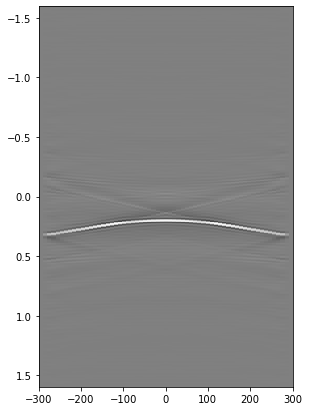

In [19]:
fig = plt.figure(figsize= (12,7))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-model.detach().numpy().max(), vmax=model.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))

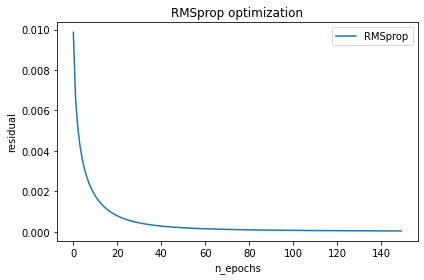

In [20]:
plt.plot(lossHist, label = "RMSprop")
plt.title('RMSprop optimization', fontsize=12)
plt.xlabel('n_epochs')
plt.ylabel('residual')
plt.legend()
plt.tight_layout()

# Adagrad optimization

In [21]:
model = np.zeros((m.shape[0], m.shape[1]))
model = torch.from_numpy(model)
model.requires_grad= True

criterion = nn.MSELoss()
optimizer4 = torch.optim.Adagrad([model], lr =0.01, eps =1e-06)


GwavTorch = GwavSGD(nt,nv,dt,dr,ns)
lossHist=[]
for i in range(150):
    data = GwavTorch(model)
    lost = criterion(d1, data)
    loss = (1/Gwav2.shape[0]) * lost
    loss.backward()
    optimizer4.step()
    optimizer4.zero_grad()

    lossHist.append(loss.item())
 
    
    if (i+1) %10 ==0:
     print(f'epoch: {i+1}, loss : {loss.item():.4f}')

lossdict["Adagrad"] = lossHist

epoch: 10, loss : 0.0028
epoch: 20, loss : 0.0019
epoch: 30, loss : 0.0013
epoch: 40, loss : 0.0010
epoch: 50, loss : 0.0008
epoch: 60, loss : 0.0007
epoch: 70, loss : 0.0006
epoch: 80, loss : 0.0005
epoch: 90, loss : 0.0004
epoch: 100, loss : 0.0004
epoch: 110, loss : 0.0003
epoch: 120, loss : 0.0003
epoch: 130, loss : 0.0003
epoch: 140, loss : 0.0002
epoch: 150, loss : 0.0002


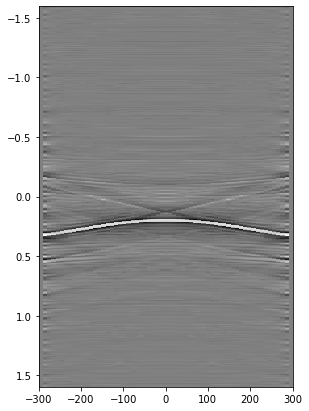

In [22]:
fig = plt.figure(figsize= (12,7))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-model.detach().numpy().max(), vmax=model.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))

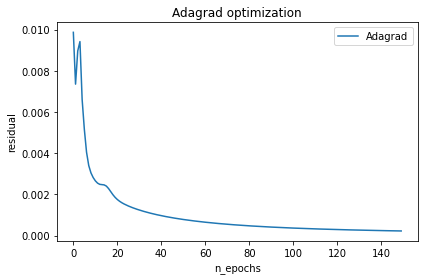

In [23]:
plt.plot(lossHist, label = "Adagrad")
plt.title('Adagrad optimization', fontsize=12)
plt.xlabel('n_epochs')
plt.ylabel('residual')
plt.legend()
plt.tight_layout()

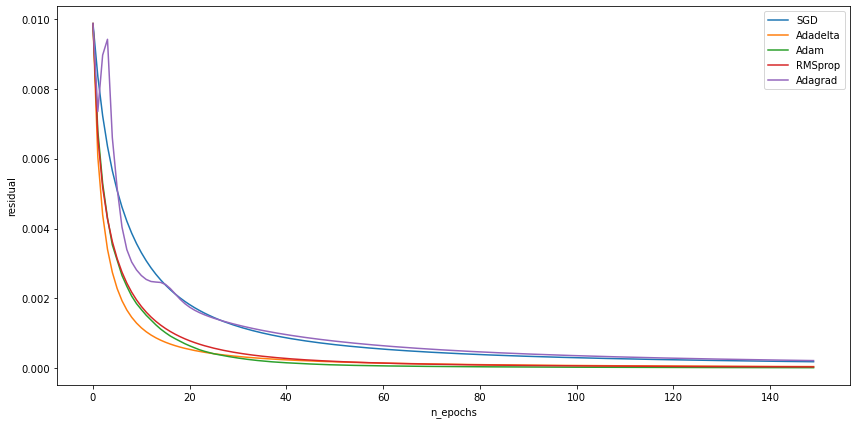

In [24]:
fig = plt.figure(figsize= (12,6))
for loss in lossdict.keys():
  
  plt.plot(lossdict[loss], label = loss)


plt.xlabel('n_epochs')
plt.ylabel('residual')
plt.legend()
plt.tight_layout()